# Part 2: PCA

In [1]:
import os
import os.path as op
from tqdm.notebook import trange, tqdm
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from nilearn.image import iter_img
from nilearn.plotting import plot_stat_map, show
from sklearn.decomposition import FastICA, PCA

from nilearn import datasets
from nilearn.input_data import NiftiMasker
from scipy.stats import zscore
from scipy.io import loadmat
from IPython.display import Image

save_results = 'results/'
if not os.path.exists(save_results):
    os.makedirs(save_results)
    
%matplotlib inline

### Load the data

In [2]:
dataset_id = 'ds000171'
subject = 'control01' 

sample_path = "/home/jovyan/Data/dataset"
bids_root = op.join(sample_path, dataset_id)
deriv_root = op.join(bids_root, 'derivatives')
preproc_root = op.join(bids_root, 'derivatives','preprocessed_data')

In [36]:
data_path = op.join(preproc_root, 'sub-control01', 'func','concatenated_bold_moco.nii.gz')#_smoothed-6mm.nii.gz')
img = nib.load(op.join(preproc_root, 'sub-control01', 'anat','coregistered_anatomical.nii.gz'))
affine = img.affine
data = np.asanyarray(img.dataobj)
data.shape

(80, 80, 50)

### Preprocessing

In [5]:
# Make variables:
# 'vol_shape' for shape of volumes
# 'n_vols' for number of volumes

vol_shape = data.shape[0:3]
n_vols = data.shape[3]

num_zero_values_after = np.sum(data == 0)
print(f"Number of zero values after standardization: {num_zero_values_after}")

Number of zero values after standardization: 81414992


Taking the timepoints as being the samples and the voxels as the features. Meaning that the colums will be voxels and rows will be samples (timepoints)

Assuming that the voxels include useless background voxels, which are assumed to be zero.

In [6]:
# Removing background
slice_non_background = np.ones(vol_shape, dtype=bool) # intialize a mask to keep track of non-background voxels
samples = data[slice_non_background, :] ##
print('original shape:', samples.shape)

for vol in range(n_vols):
    slice_non_background &= (data[:, :, :, vol] != 0) # use AND with every voxel in every volume to update mask

samples = data[slice_non_background, :].T ## shape should be (n_timepoints, n_voxels)
print('shape after removing background', samples.shape)

if np.any(samples == 0):
    print("Warning: There are still zero values in the samples array!")


original shape: (320000, 315)
shape after removing background (315, 55178)


Removing the spatial mean across timepoints from each timepoints. Calculates the mean spatial pattern and perform the substraction operation.

In [7]:
# Calculate the mean across columns
spatial_means = np.mean(samples, axis=1, keepdims=True) # shape (n_timepoints, 1)
# Row means copied n_vols times so that we substract for each timepoint the spatial mean
row_means = ...
# Subtract the means for each row, put the result into X
X = samples - spatial_means

# Verify that the spatial mean behaves as expected after substraction
# Calculate the mean across time for each voxel to chek if its close to zero 
verification_means = np.mean(X, axis=1)

# Print verification result
print("Verification (should be close to zero):", np.round(verification_means, decimals=4))


Verification (should be close to zero): [ 0.  0.  0. -0.  0. -0.  0.  0.  0.  0. -0. -0. -0.  0. -0.  0.  0. -0.
  0.  0.  0. -0.  0.  0.  0.  0.  0.  0. -0.  0.  0. -0.  0. -0.  0.  0.
 -0.  0. -0.  0. -0.  0. -0. -0.  0.  0. -0.  0.  0.  0.  0.  0. -0.  0.
  0. -0. -0.  0.  0.  0. -0. -0. -0.  0.  0.  0.  0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0.  0.  0.  0.  0.  0. -0.  0. -0. -0. -0.  0.  0.  0. -0.
 -0. -0. -0.  0.  0.  0.  0. -0. -0. -0. -0.  0. -0. -0.  0. -0. -0. -0.
 -0.  0.  0. -0. -0. -0.  0.  0.  0. -0. -0. -0. -0. -0.  0. -0. -0.  0.
  0.  0.  0.  0. -0. -0.  0. -0. -0.  0.  0.  0. -0. -0.  0. -0. -0. -0.
  0.  0.  0. -0. -0.  0.  0.  0. -0.  0.  0.  0.  0. -0. -0.  0. -0.  0.
  0.  0. -0.  0.  0.  0. -0. -0. -0.  0.  0.  0.  0. -0.  0.  0.  0.  0.
  0. -0. -0. -0.  0. -0. -0.  0.  0. -0. -0.  0. -0. -0. -0. -0.  0.  0.
 -0.  0.  0. -0. -0. -0.  0.  0.  0. -0.  0. -0.  0.  0.  0.  0. -0. -0.
  0.  0. -0. -0. -0. -0.  0.  0. -0.  0.  0. -0.  0. -0. -0.  0.  0.  0.
  0. -0. -0

Chose this verification method since by subtracting the mean for each voxel across all time points, we make the time series of each voxel have an average value of zero. 

In [8]:
X.shape

(315, 55178)

## Components extraction

In [9]:
from sklearn.decomposition import PCA
nb_components = 10 # Arbitrary number

pca = PCA(n_components=nb_components)

# Fit the PCA model to the data (where samples are voxels and features are time points)
pca.fit(X)

# Retrieve the principal components
components = pca.components_  # Shape (nb_components, n_timepoints)
explained_variance = pca.explained_variance_ratio_

print("Explained variance by each component:", explained_variance)
print("Components shape:", components.shape)

Explained variance by each component: [0.63763857 0.07220466 0.0352264  0.02006321 0.01610782 0.01095344
 0.00920209 0.00804774 0.00755263 0.00671213]
Components shape: (10, 55178)


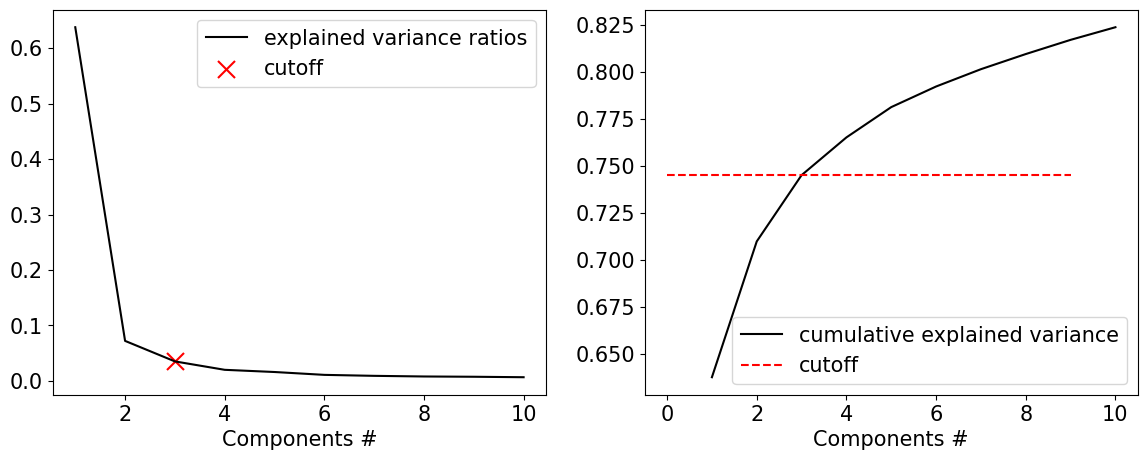

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(14,5))

ratios = pca.explained_variance_ratio_
cumulative_ratios = np.cumsum(pca.explained_variance_ratio_)
nb_clusters = 3

ax[0].plot(np.arange(1, len(ratios)+1), ratios, label='explained variance ratios', c='k')
ax[0].scatter([nb_clusters], [ratios[nb_clusters-1]], [150], marker='x', color='r', label='cutoff')
ax[1].plot(np.arange(1, len(cumulative_ratios)+1), cumulative_ratios, label='cumulative explained variance', c='k')
ax[1].hlines(y=cumulative_ratios[nb_clusters-1], xmin=0, xmax=len(ratios)-1, linestyle='--', color='r', label='cutoff')

for k in range(2):
    ax[k].set_xlabel('Components #', size=15)
    ax[k].legend(prop={'size':15})
    ax[k].tick_params(axis='both', which='major', labelsize=15)

In [11]:

# Initialize an empty list to store each spatial component as a 3D volume
pca_clusters = []

# For each component, reshape it back to the original spatial shape using the mask
for spatial_component in components:
    # Step 1: Initialize a 3D volume with the original shape, filled with zeros or NaN
    component_volume = np.zeros(vol_shape)  # Or use np.full(vol_shape, np.nan) for NaNs

    # Step 2: Place the values from the component back into the spatial volume
    component_volume[slice_non_background] = spatial_component

    # Step 3: Append the reshaped 3D volume to the list
    pca_clusters.append(component_volume)

# `pca_clusters` now contains reconstructed spatial volumes for each PCA component


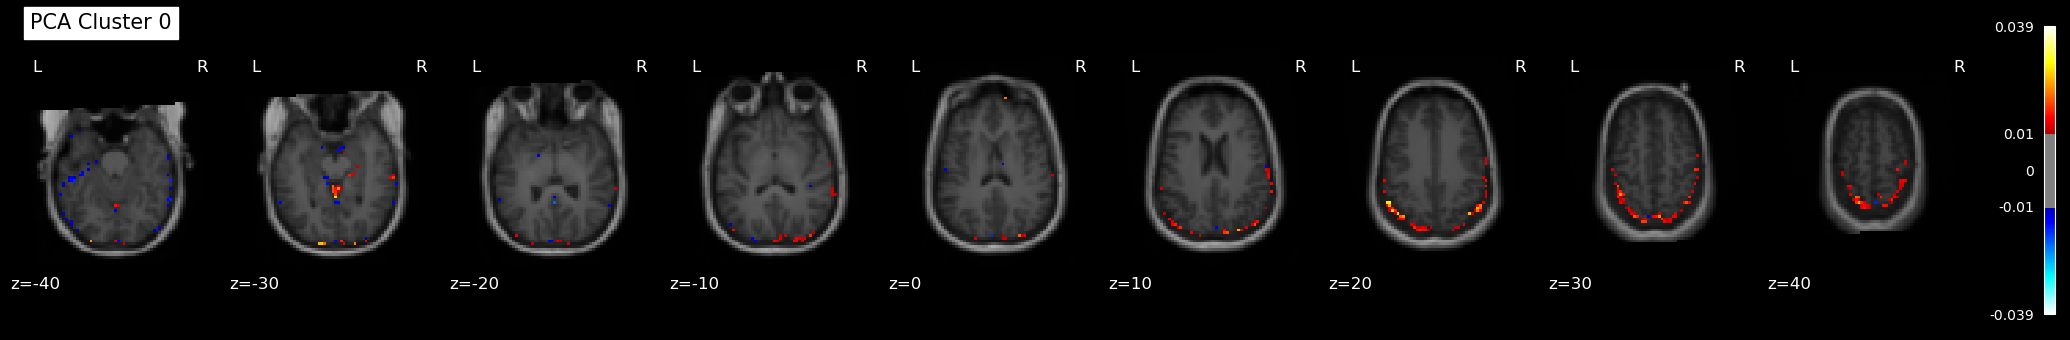

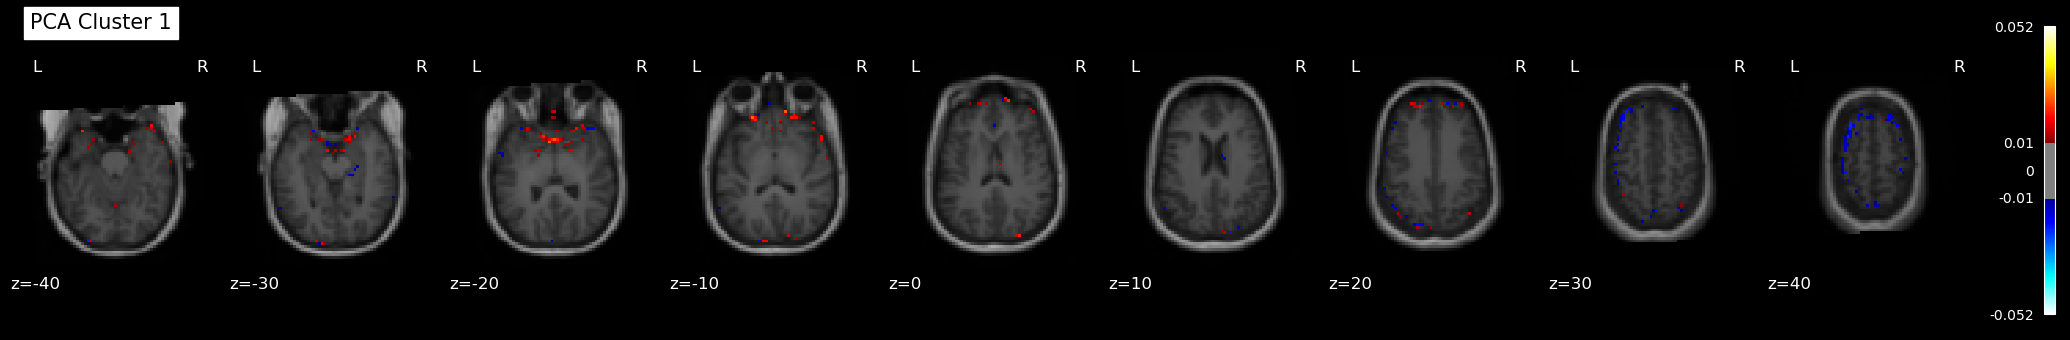

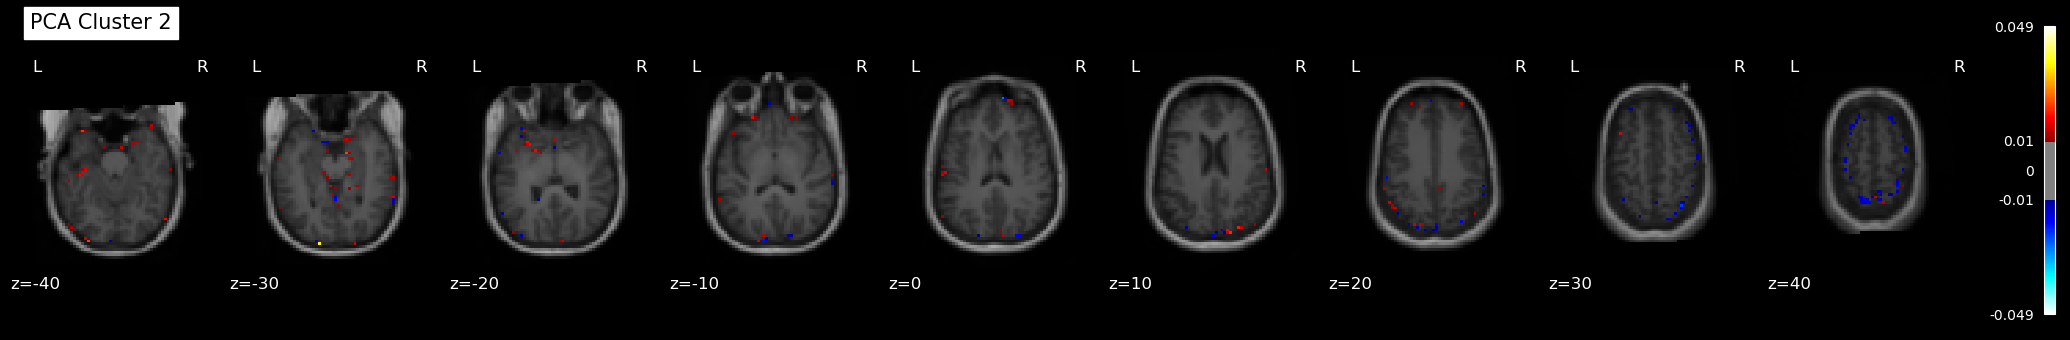

In [49]:
from nilearn.plotting import plot_stat_map
from nilearn.image import mean_img
mean_img_ = mean_img(img)

for visual_idx in range(nb_clusters):
    plot_stat_map(nib.Nifti1Image(pca_clusters[visual_idx], affine), bg_img=mean_img_, threshold=0.01,
                   cut_coords=[-40, -30, -20, -10, 0, 10, 20, 30, 40], black_bg=True, display_mode = "z",
                  title=f'PCA Cluster {visual_idx}')

plt.show()